#### Daibetes of a Patient - Readmision in Hospital

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import skew
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
# pip install imblearn

In [3]:
# pip install --upgrade threadpoolctl

In [4]:
df = pd.read_csv(r"E:\Datasets\Shilpa\diabetic_data.csv")
pd.set_option('display.max_columns', None)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Exploratory Data Analysis

In [5]:
df.shape

(101766, 50)

#### Drop columns with single values or irrelevant identifiers

In [6]:
drop_cols = ['encounter_id','patient_nbr','weight','payer_code','medical_specialty',
             'examide', 'citoglipton','diag_1','diag_2','diag_3']
df.drop(columns = drop_cols, inplace = True)
df.shape

(101766, 40)

In [7]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace = True)

#### Check missing values

In [8]:
print(df.isnull().sum().sort_values(ascending = False).head(10))

max_glu_serum               96420
A1Cresult                   84748
race                         2273
gender                          0
discharge_disposition_id        0
admission_source_id             0
age                             0
admission_type_id               0
num_lab_procedures              0
time_in_hospital                0
dtype: int64


#### Ploting the missing in Patient Records (Sparsity)

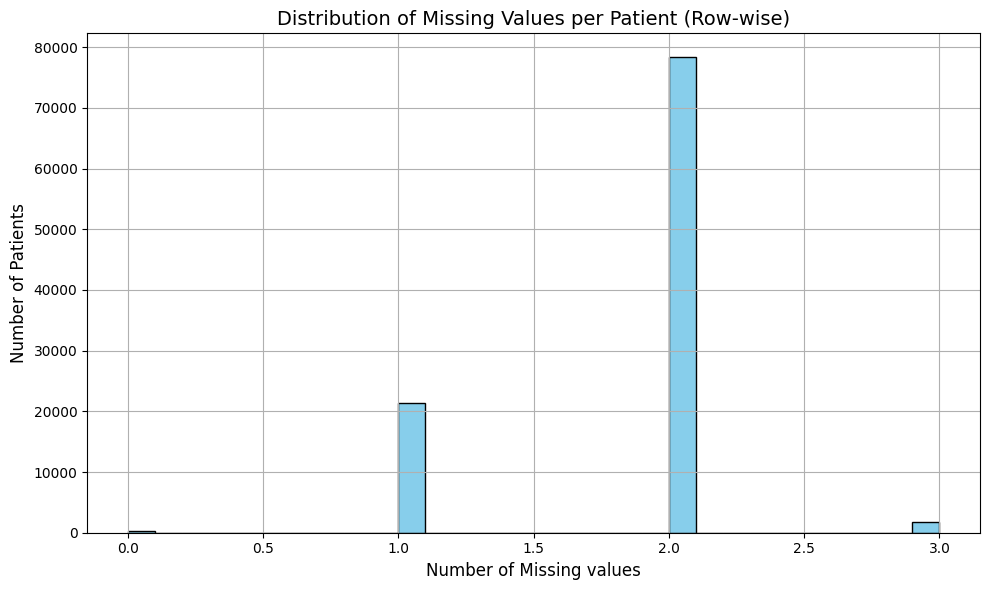

In [9]:
pt_sparsity = df.isnull().apply(sum, axis=1)

plt.figure(figsize = (10,6))
plt.hist(pt_sparsity, bins=30, edgecolor='black', color='skyblue')
plt.title("Distribution of Missing Values per Patient (Row-wise)", fontsize=14)
plt.xlabel('Number of Missing values', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Exploring the column 'race'

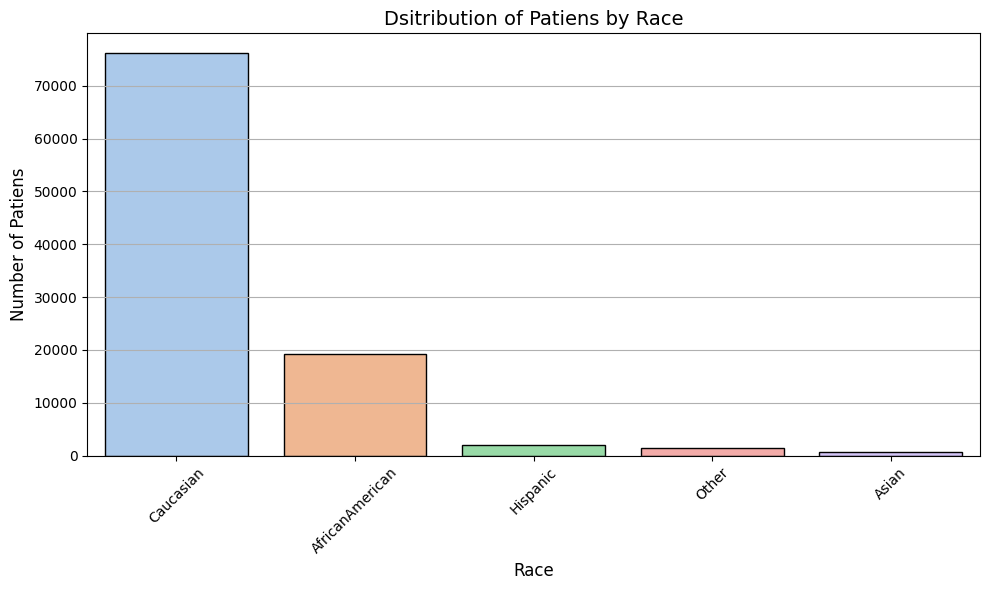

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='race', order = df['race'].value_counts().index,
             palette='pastel',edgecolor='black')

plt.title('Dsitribution of Patiens by Race', fontsize=14)
plt.xlabel('Race',fontsize=12)
plt.ylabel('Number of Patiens', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

- Clearly,'Caucasian' race dominates

#### Exploring 'discharg_disposition_id' informs where patient gone after discharge

Checking % of Patients Expired (Code 11,19,20,21)

In [11]:
expired_codes = [11,19,20,21]
num_expired = df[df['discharge_disposition_id'].isin(expired_codes)].shape[0]

percent_expired = (num_expired / df.shape[0])*100
print(f"Percentage of expired patients: {percent_expired:.2f}%")

Percentage of expired patients: 1.62%


In [12]:
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [13]:
df.shape

(99343, 40)

- 11,13,14,19,20,21 - represents death or hospice and cannot be returned state
- It filter out certain rows with this values from dataset

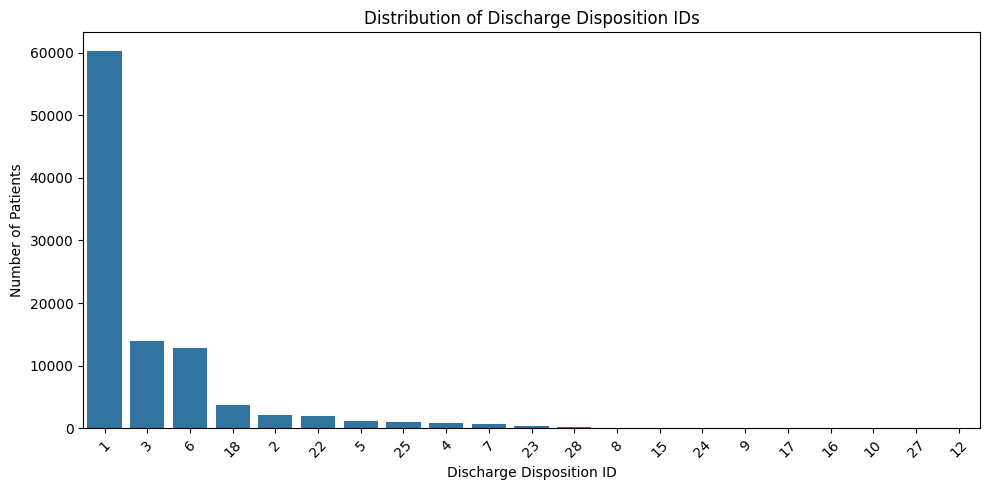

In [14]:
# Plotting remaining
plt.figure(figsize = (10,5))
sns.countplot(x='discharge_disposition_id', data=df, 
             order=df['discharge_disposition_id'].value_counts().index)
plt.title('Distribution of Discharge Disposition IDs')
plt.xlabel('Discharge Disposition ID')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- 1 - Discharged to home
- 3 - Discharged/transferred to skilled nursing facility
- 6 - Discharged/transferred to home with home health service

#### Exploring Numerical Columns

In [15]:
num_cols = df.select_dtypes(include='number').columns.tolist()
for num_col in num_cols:
    print(num_col)

admission_type_id
discharge_disposition_id
admission_source_id
time_in_hospital
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
number_diagnoses


In [16]:
cols_to_remove = ['admission_type_id','discharge_disposition_id',
                  'admission_source_id']
for col in num_cols:
    if col in cols_to_remove:
        num_cols.remove(col)
for num_col in num_cols:
    print(num_col)

discharge_disposition_id
time_in_hospital
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
number_diagnoses


In [17]:
# Converting to dataframe
df_num_cols = df[num_cols]
df_num_cols = pd.concat([df_num_cols], axis=1)

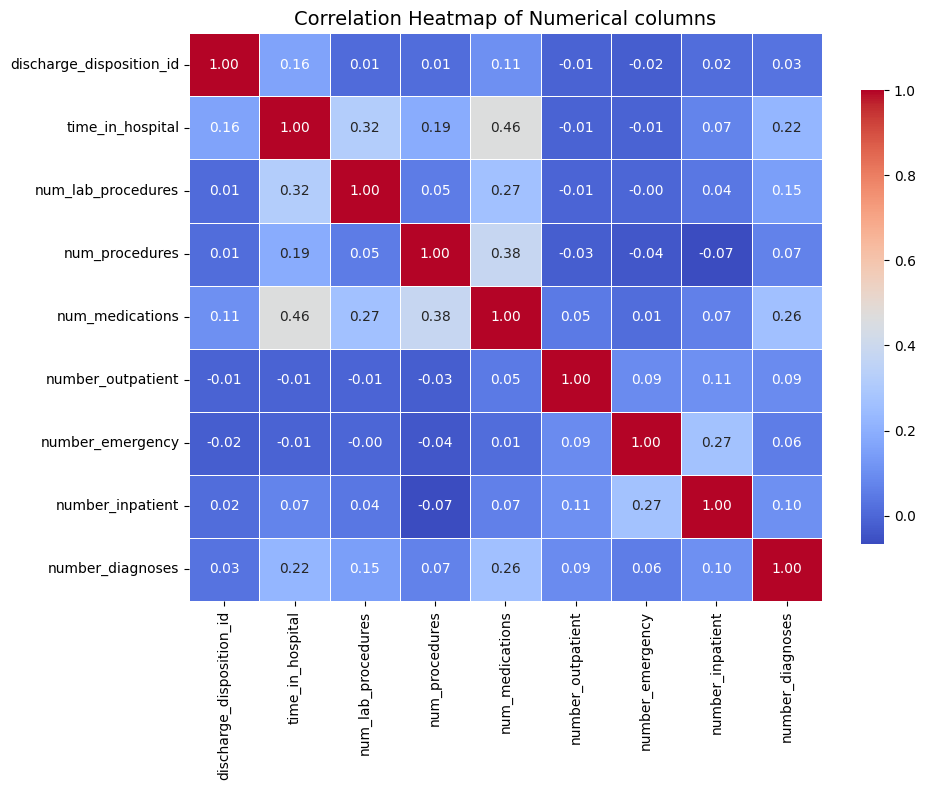

In [18]:
corr = df_num_cols.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f',
            linewidth=0.5, cbar_kws={'shrink':0.8})
plt.title('Correlation Heatmap of Numerical columns', fontsize=14)
plt.tight_layout()
plt.show()

#### Exploring Categorical Columns

In [19]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('readmitted')
print(cat_cols)

['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [20]:
df['race'] = df['race'].fillna('UKN')

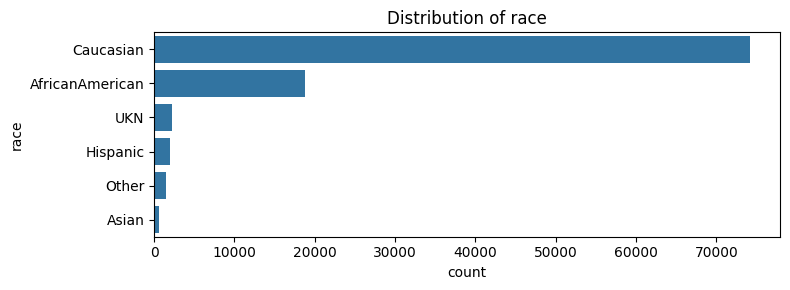

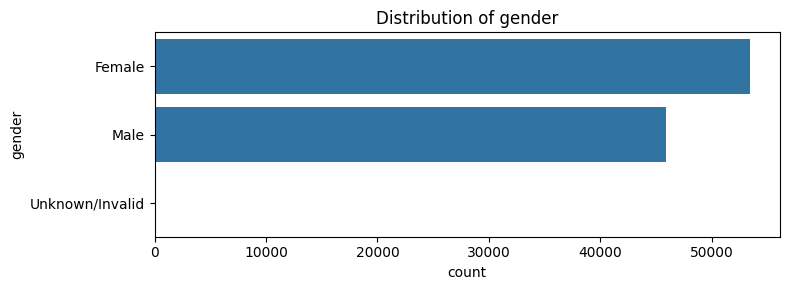

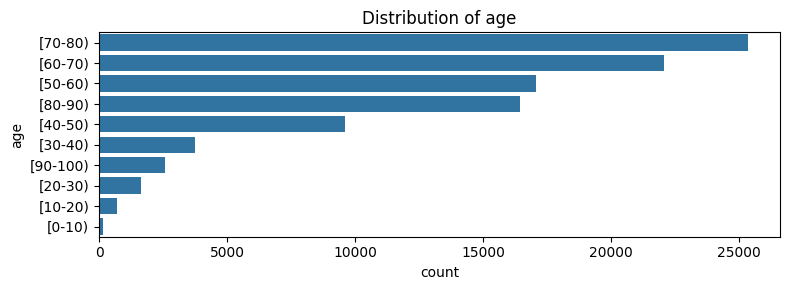

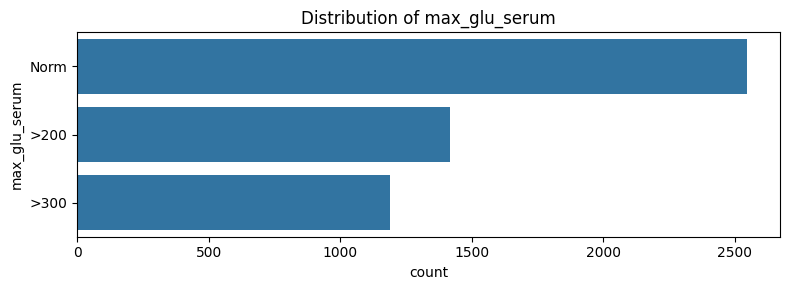

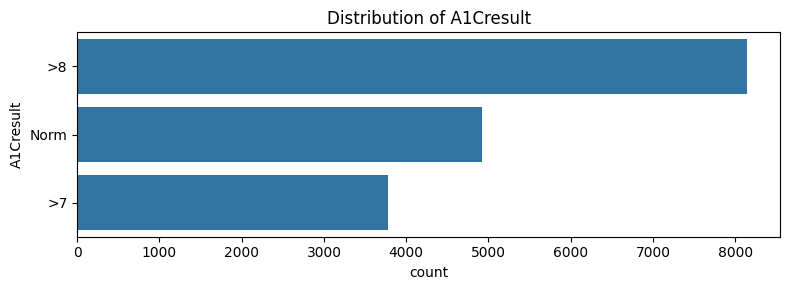

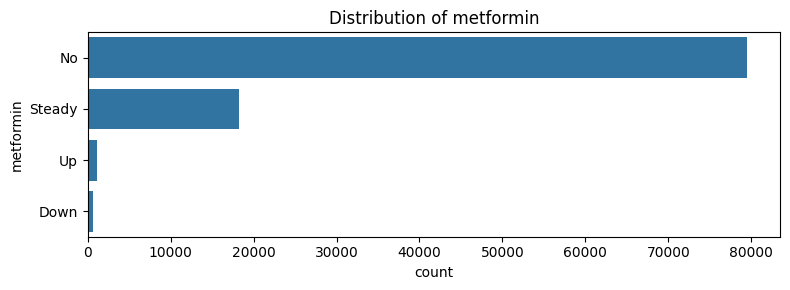

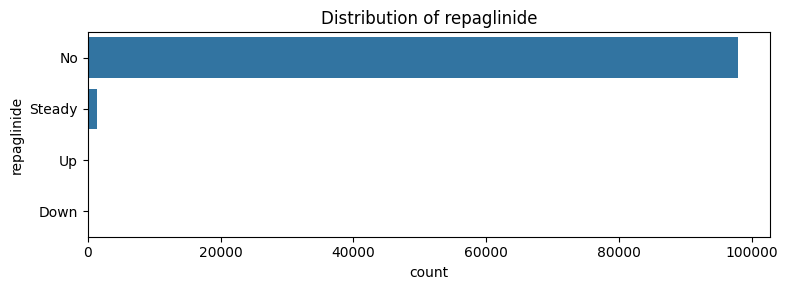

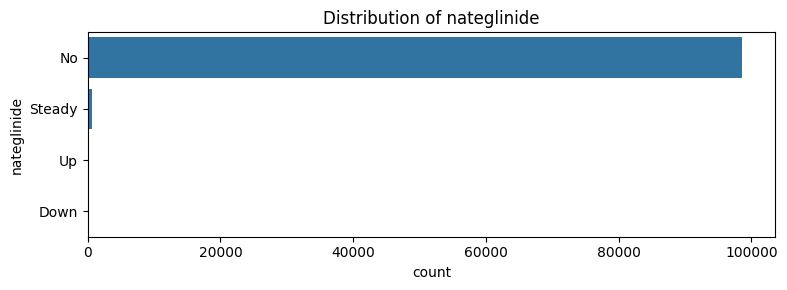

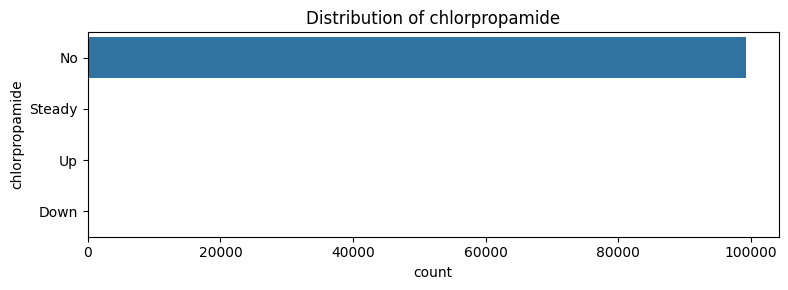

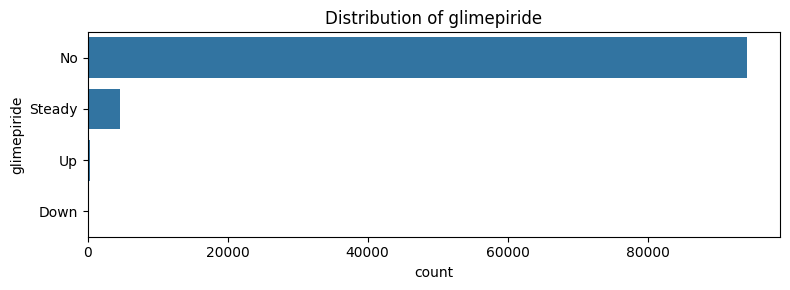

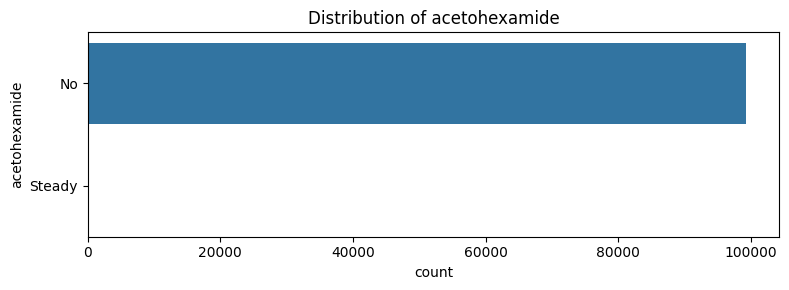

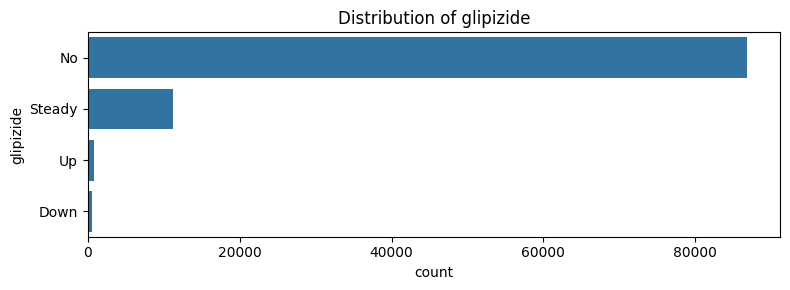

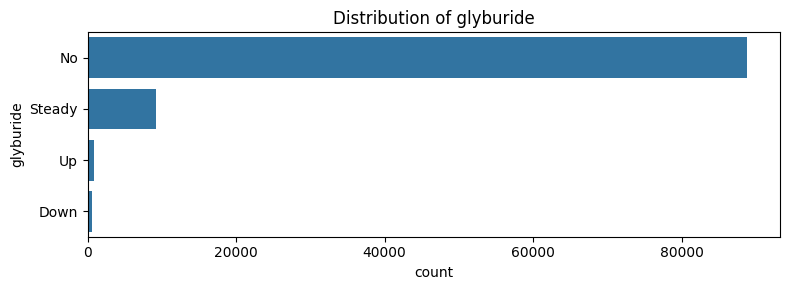

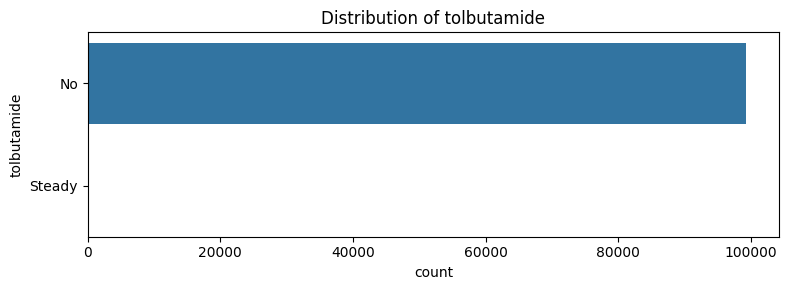

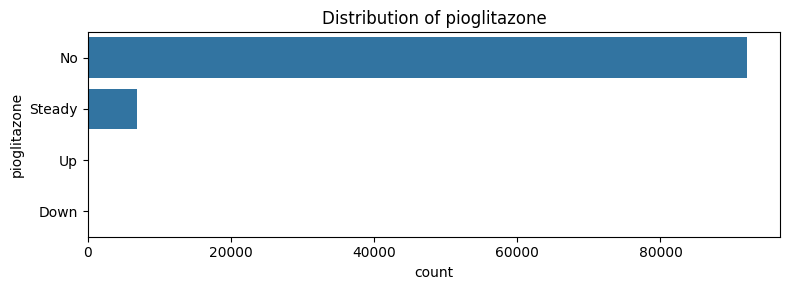

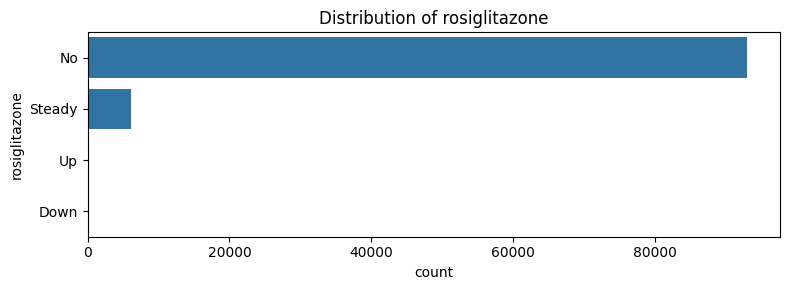

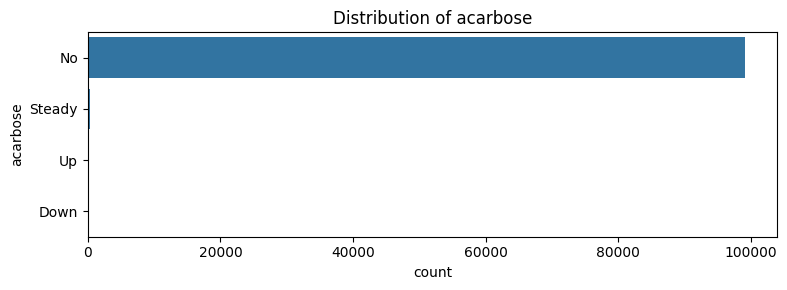

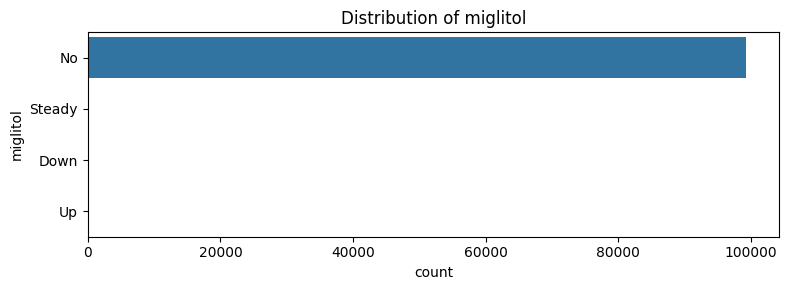

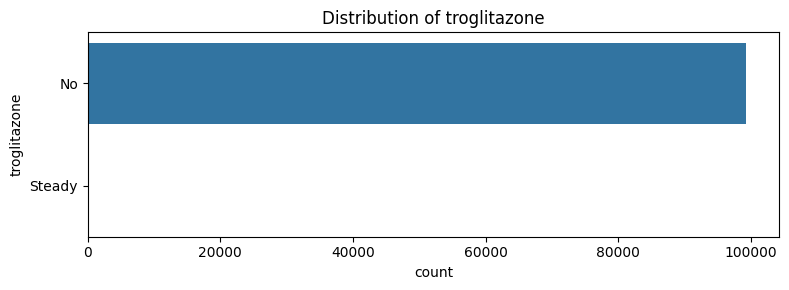

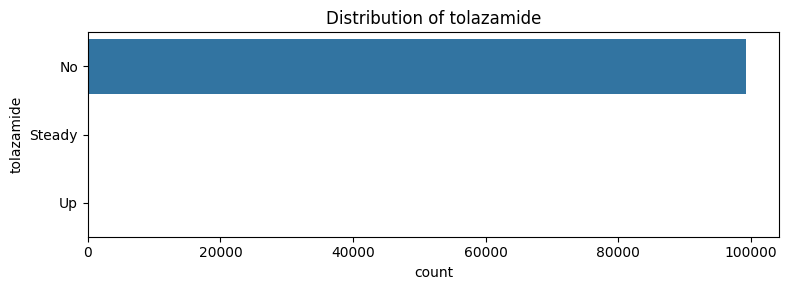

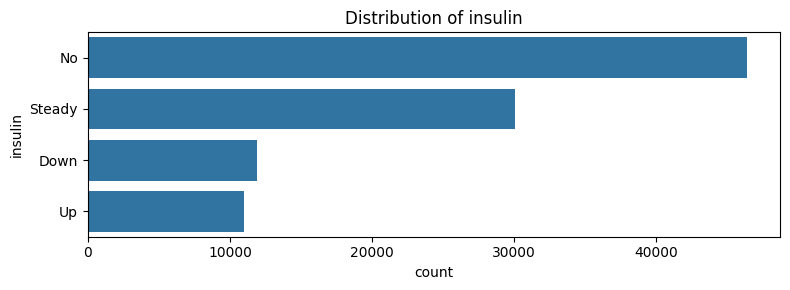

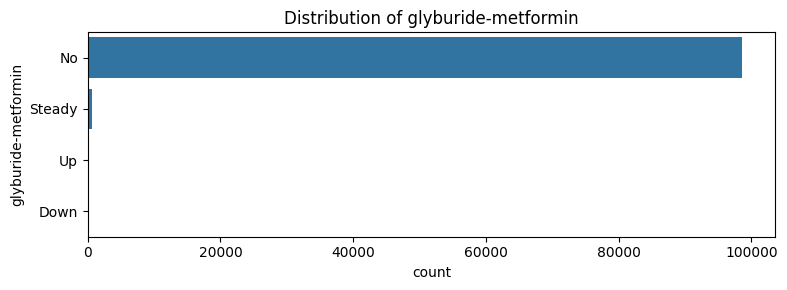

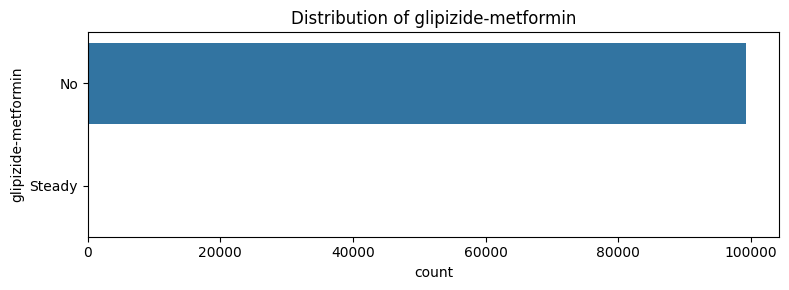

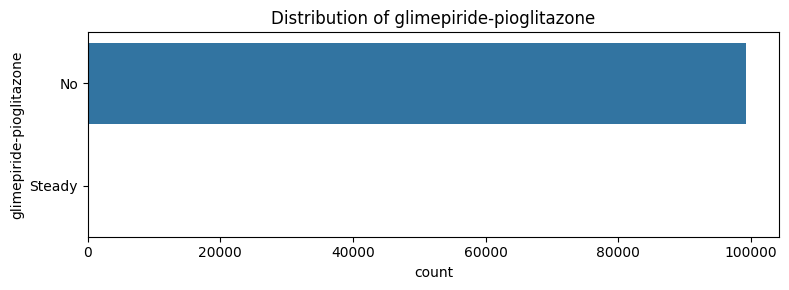

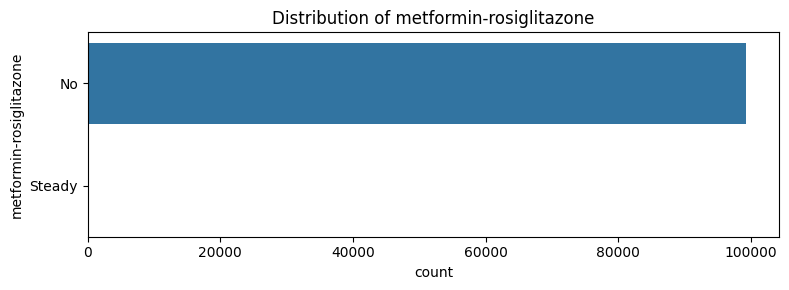

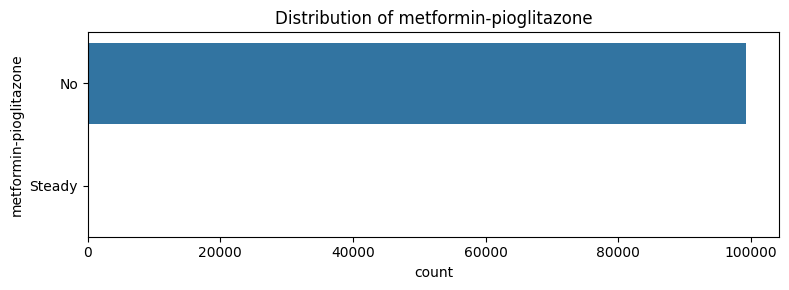

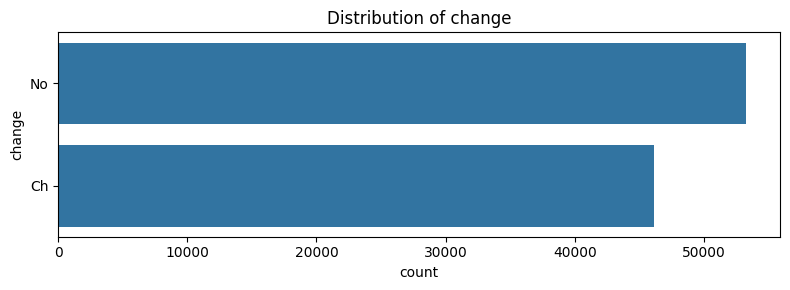

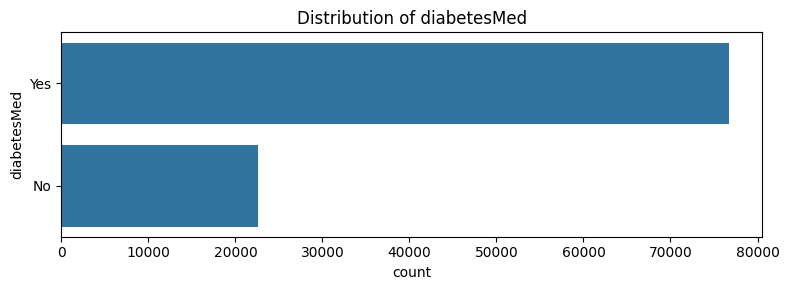

In [21]:
# Top Categories for each
for col in cat_cols:
    plt.figure(figsize=(8,3))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

#### Explore 'gender'

In [22]:
df['gender'].value_counts()

gender
Female             53454
Male               45886
Unknown/Invalid        3
Name: count, dtype: int64

In [23]:
df['gender'].replace('Unknown/Invalid', np.nan, inplace=True)
df.dropna(subset=['gender'], how='all', inplace=True)
df['gender'].value_counts()

gender
Female    53454
Male      45886
Name: count, dtype: int64

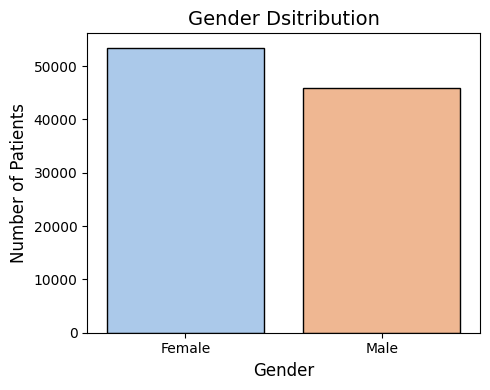

In [24]:
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='gender', palette='pastel', edgecolor='black')
plt.title('Gender Dsitribution', fontsize=14)
plt.xlabel('Gender',fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.tight_layout()
plt.show()

#### Target Distribution (Readmitted)

In [25]:
df['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

In [26]:
df['readmitted'] = df['readmitted'].replace({'>30':'NO', '<30':'YES','NO':'NO'})

In [27]:
# df['readmitted'] = [1 if val=='<30' else 0 for val in df['readmitted']]

#### Explore 'age','gender' and 'race'

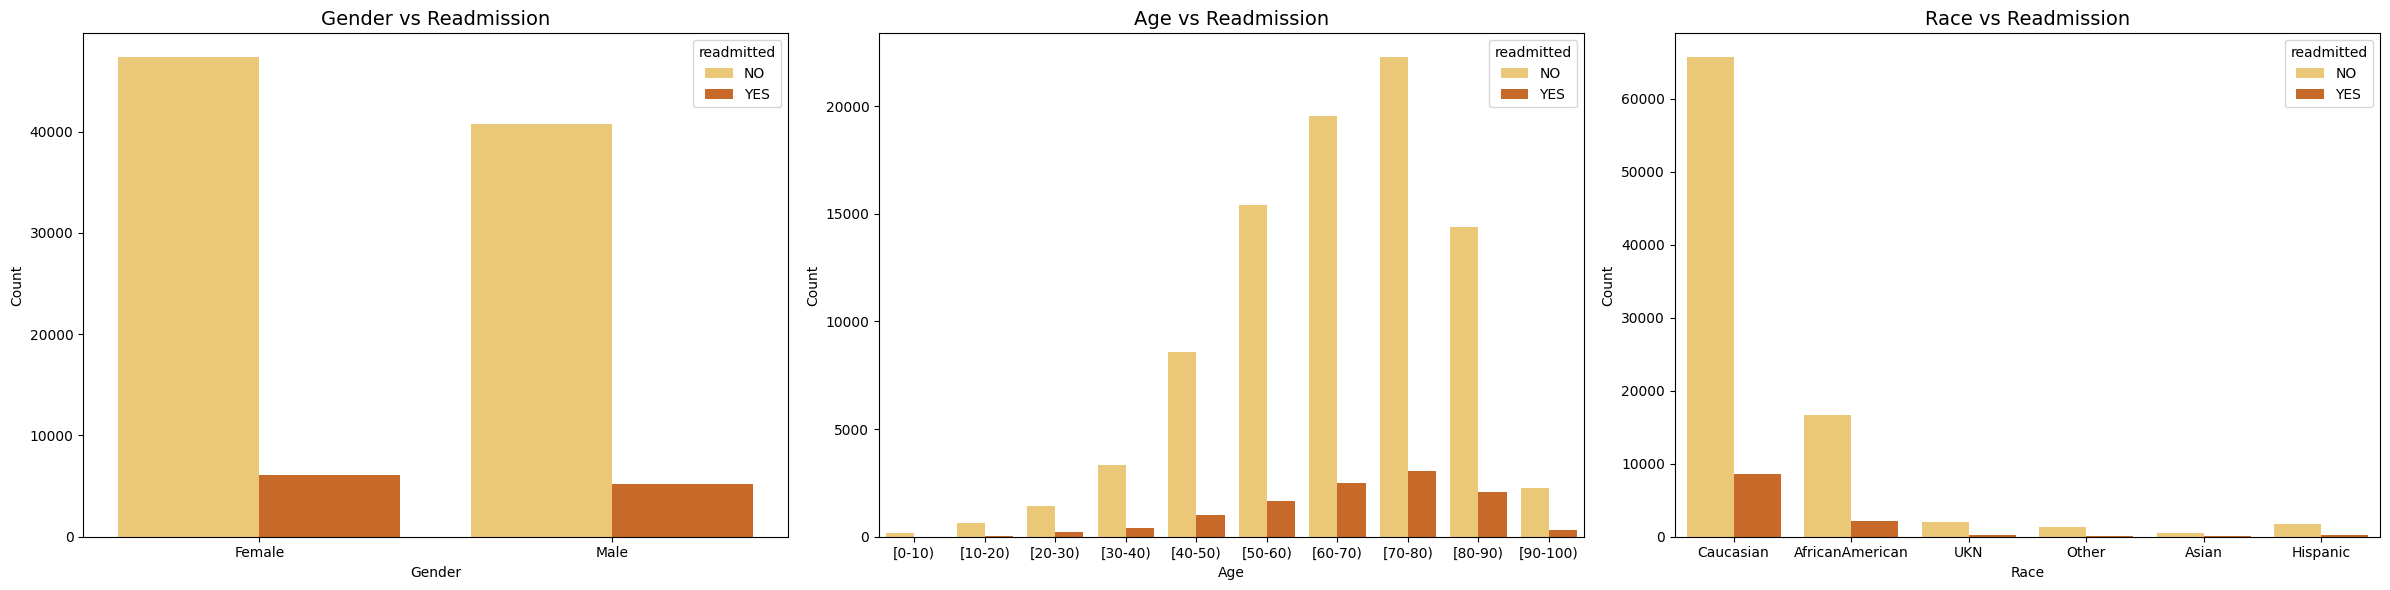

In [28]:
visual_cols = ['gender', 'age', 'race']

# setup subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6))

# loop through each col and plot countplot with hue
for idx, col in enumerate(visual_cols):
    sns.countplot(data=df, x=col, hue='readmitted', palette='YlOrBr', ax=ax[idx])
    ax[idx].set_title(f"{col.capitalize()} vs Readmission", fontsize=14)
    ax[idx].set_xlabel(col.capitalize())
    ax[idx].set_ylabel('Count')
plt.tight_layout()
plt.show()

#### Explaring Special Features related to medications

In [29]:
med_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide',
     'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]

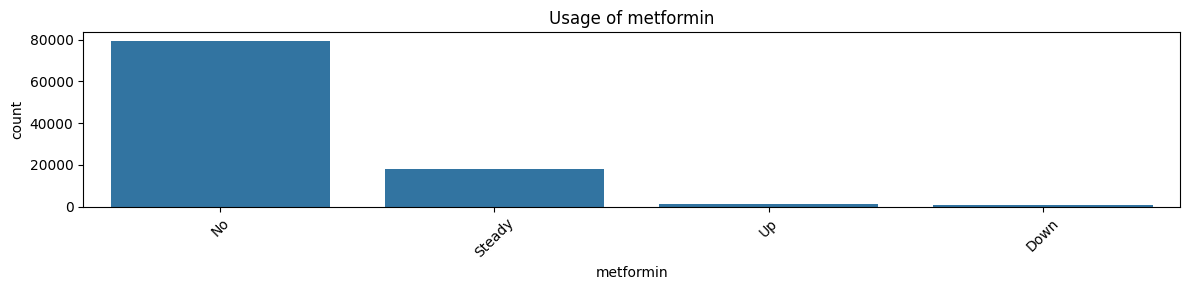

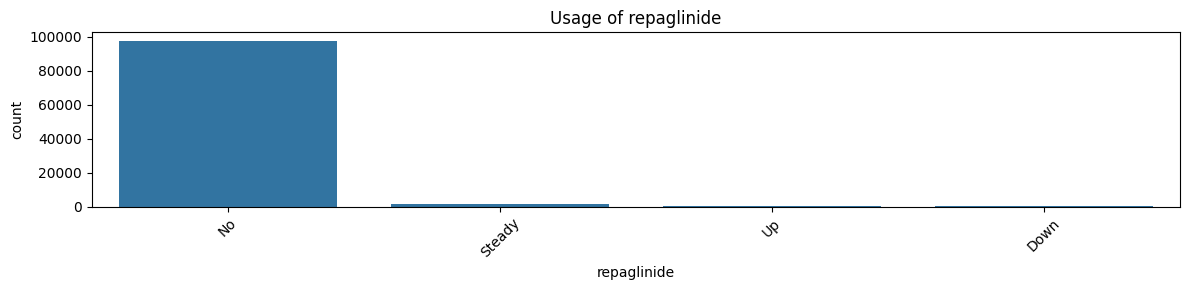

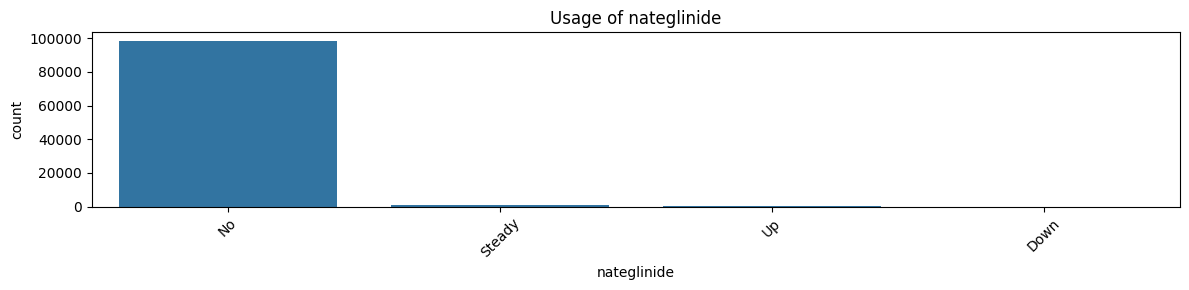

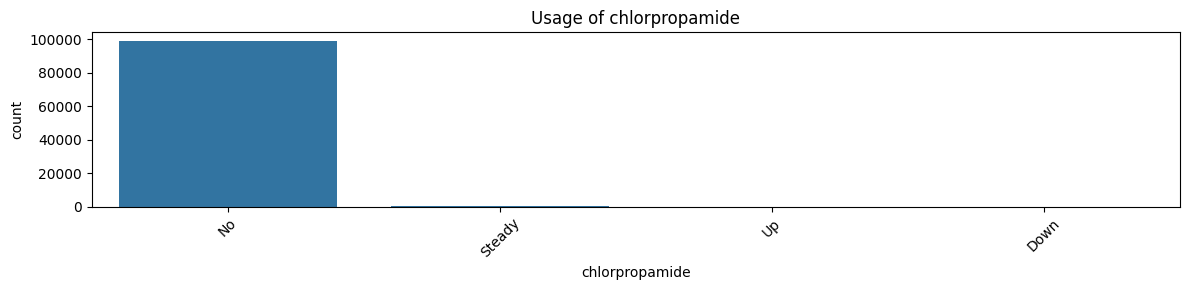

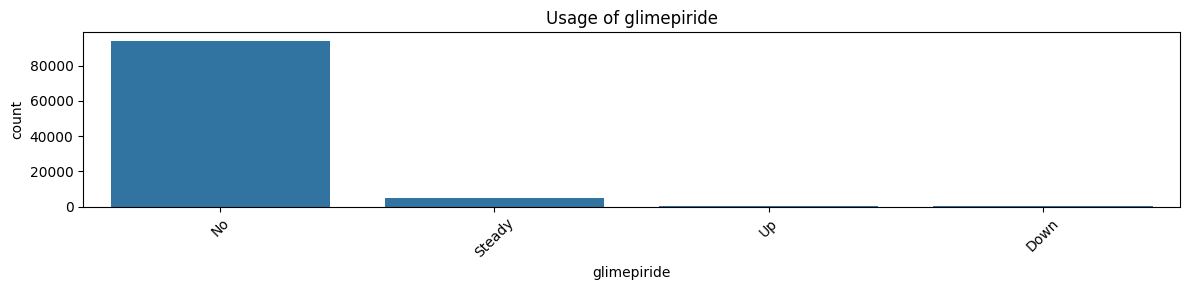

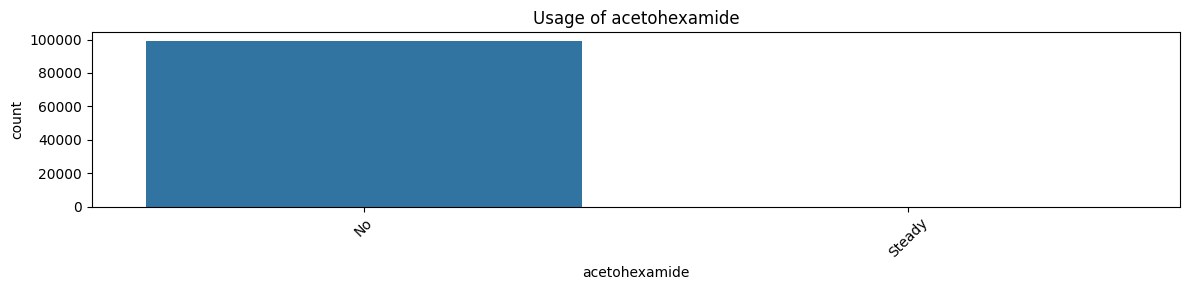

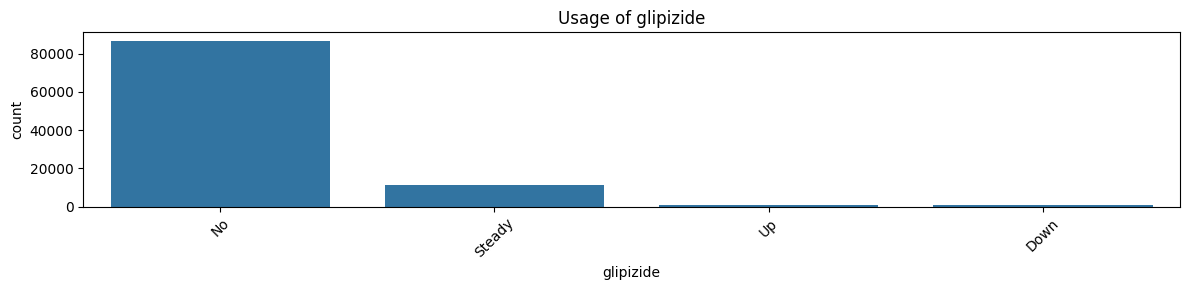

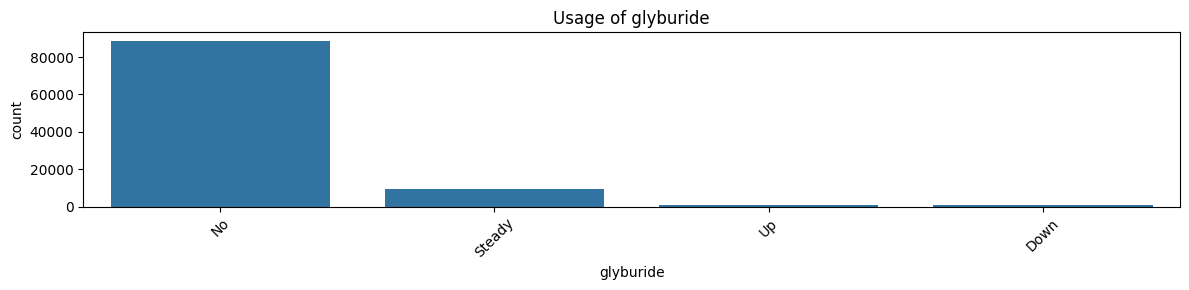

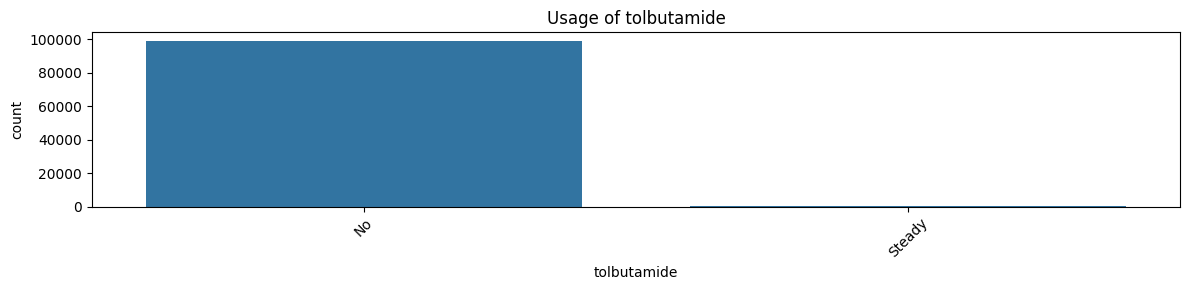

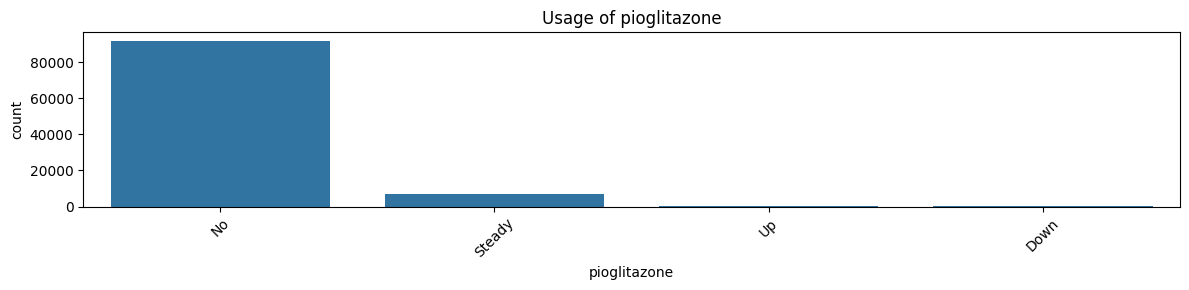

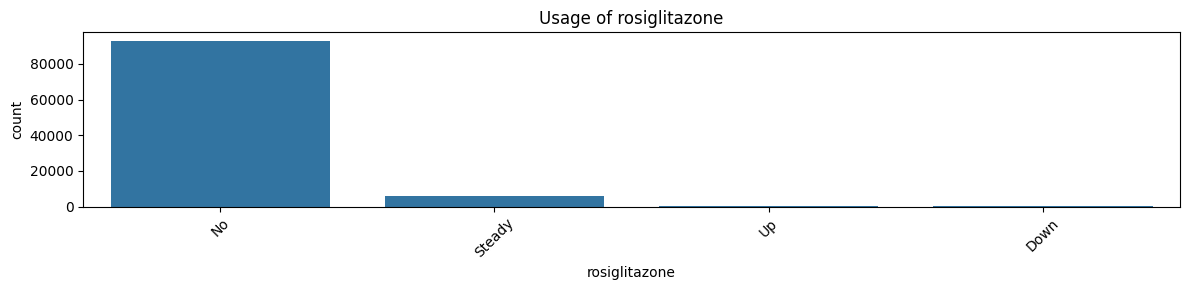

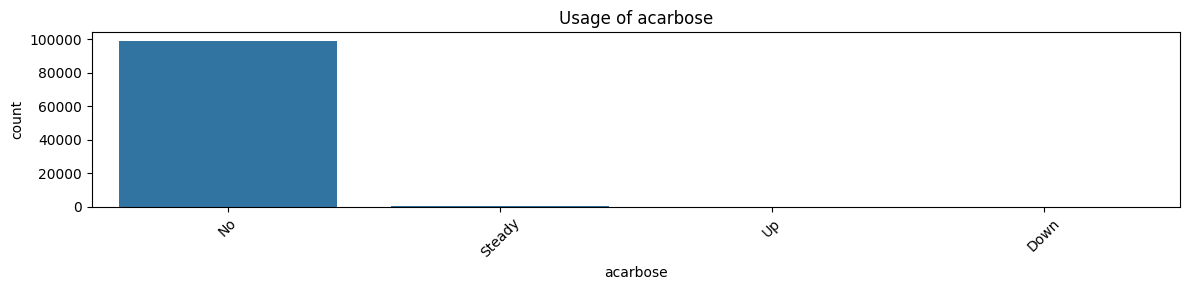

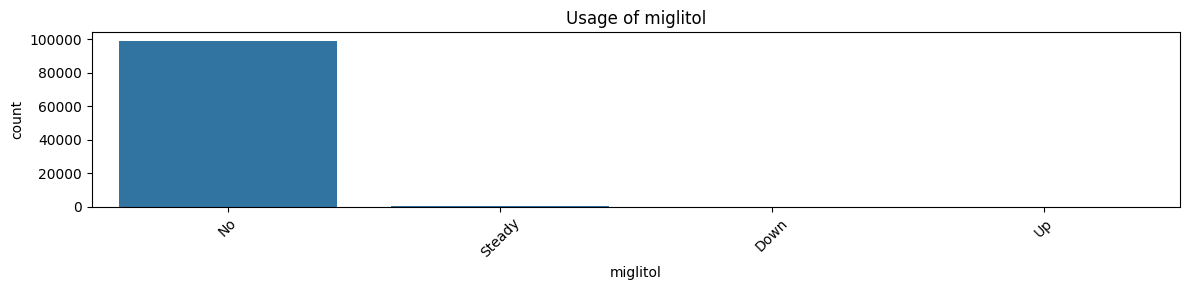

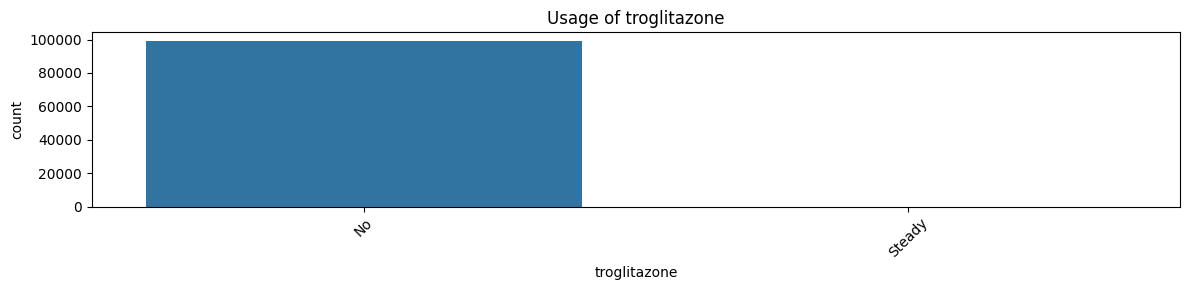

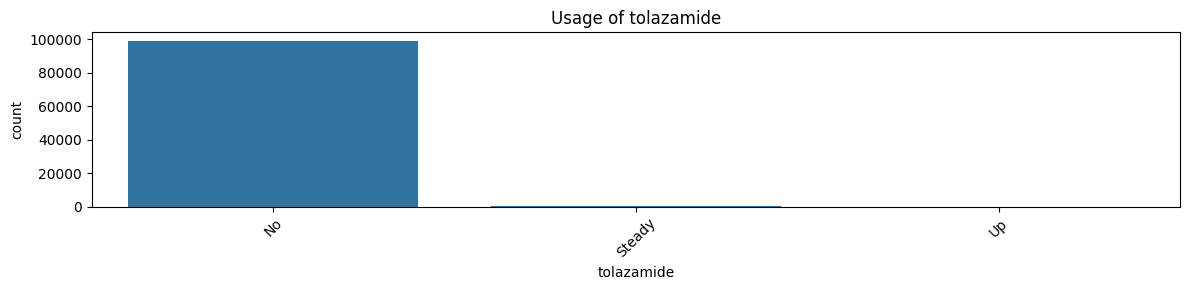

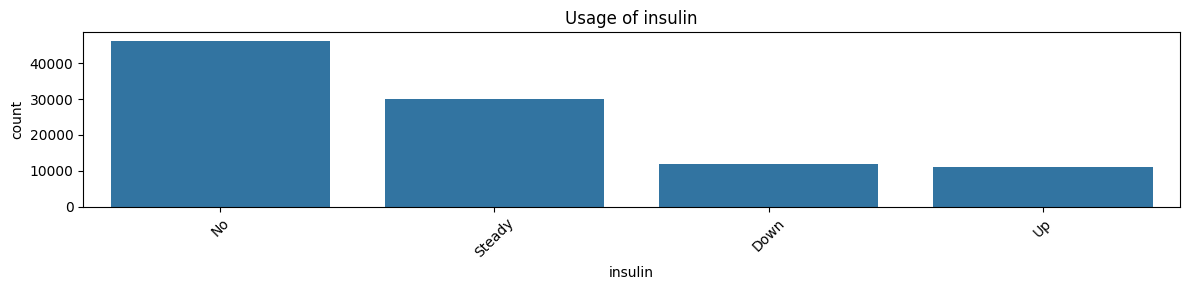

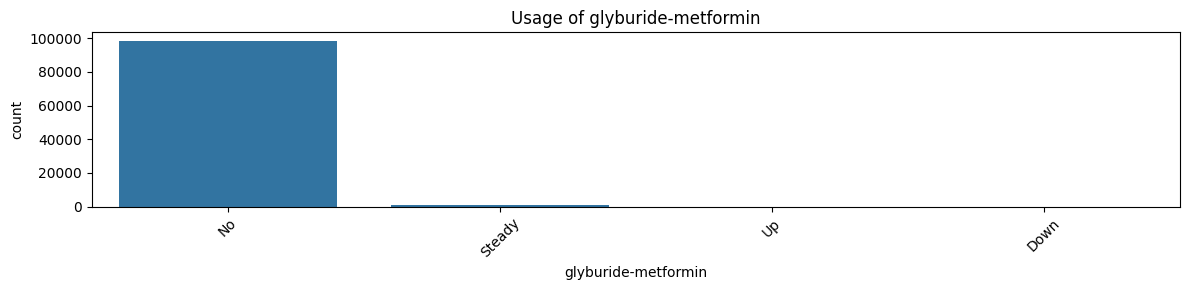

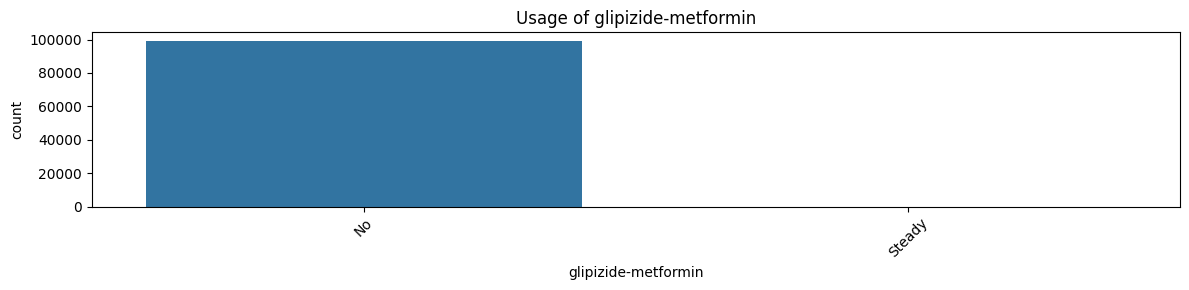

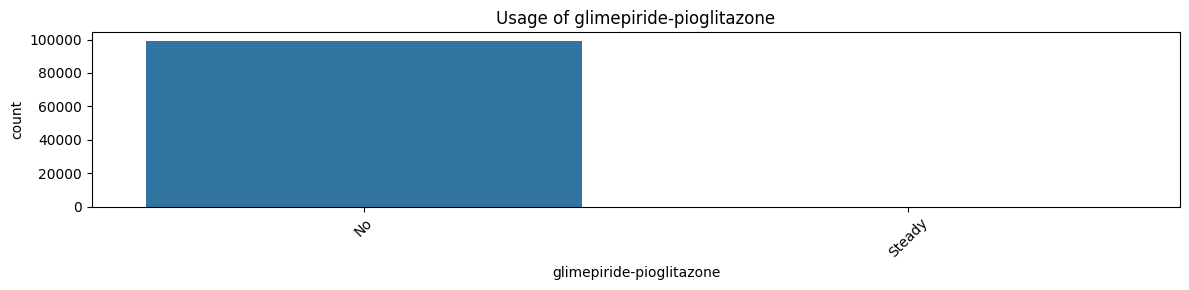

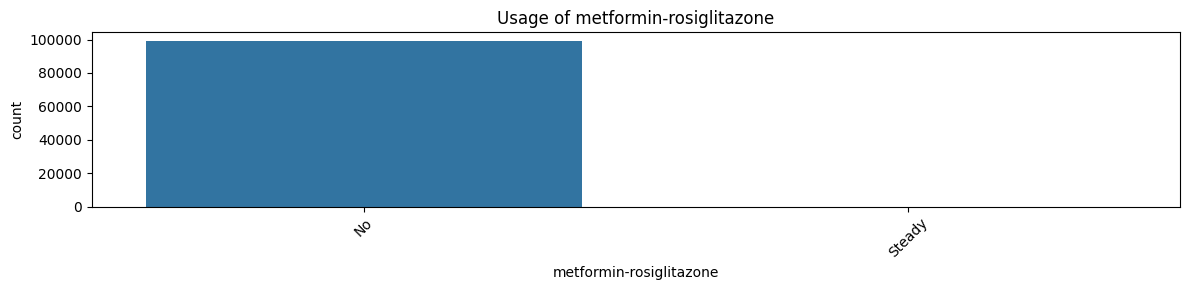

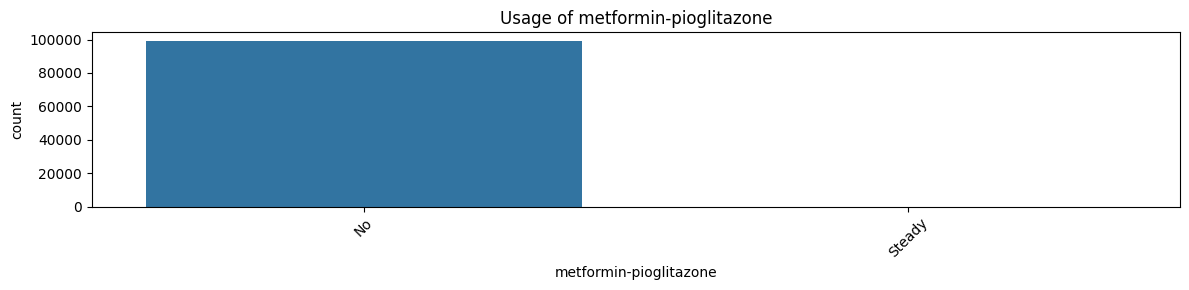

In [30]:
for col in med_cols:
    plt.figure(figsize=(12,3))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Usage of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#### Explore 'time_in_hospital' (Stay vs Readmission)

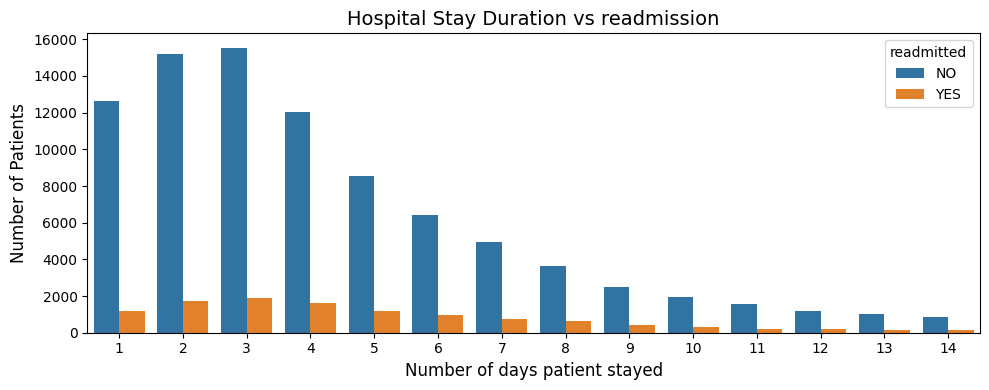

In [31]:
plt.figure(figsize=(10,4))
sns.countplot(x='time_in_hospital', hue='readmitted', data=df)
plt.title('Hospital Stay Duration vs readmission', fontsize=14)
plt.xlabel('Number of days patient stayed',fontsize=12)
plt.ylabel('Number of Patients',fontsize=12)
plt.tight_layout()
plt.show()

#### Exploring features related to Lab Procedures and Visits

In [32]:
lab_cols = ['num_lab_procedures', 'num_medications', 'number_outpatient',
            'number_emergency', 'number_inpatient']

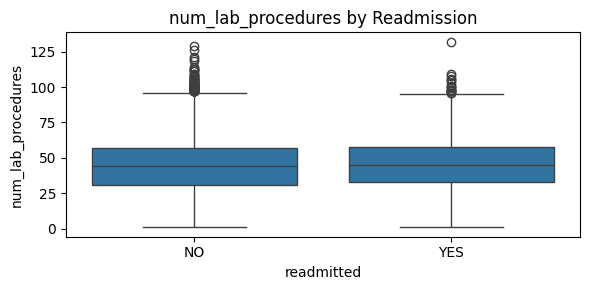

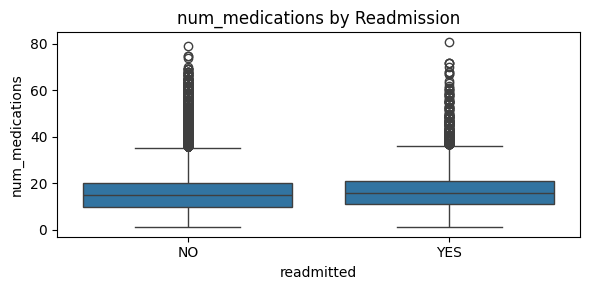

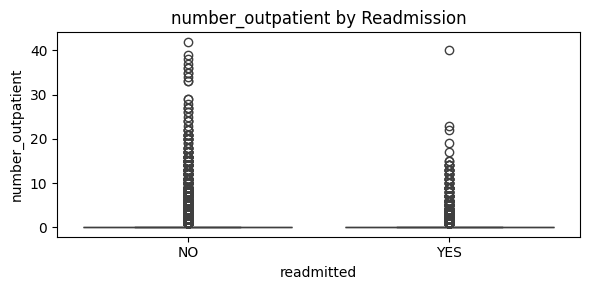

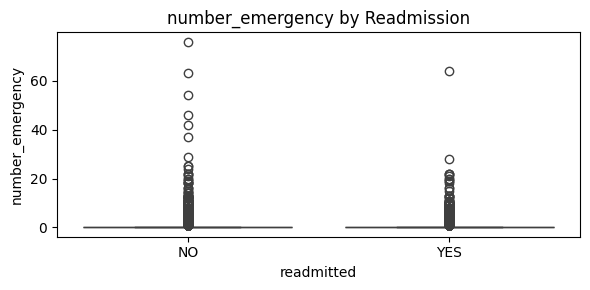

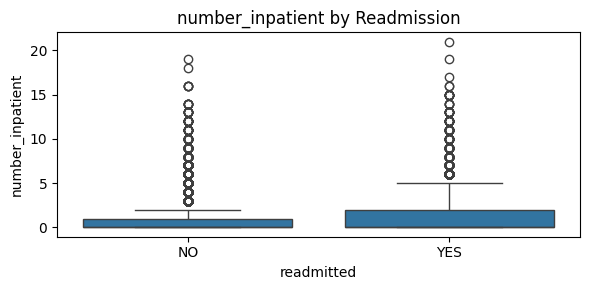

In [33]:
for col in lab_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='readmitted', y=col, data=df)
    plt.title(f"{col} by Readmission")
    plt.tight_layout()
    plt.show()

### Data Cleaning

#### Encode Target Column

In [34]:
df['readmitted'] = df['readmitted'].map({'NO':0, 'YES':1})

#### Encode Categorical Features (LabelEncoder)

In [35]:
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str)) # Safe casting

#### Remove near-constant or irrelevant features

##### Removes features with variance < 0.01  bcoz they are uninformative for predictions

In [36]:
X_temp = df.drop(columns = 'readmitted') # no need to check the variance of target
variance_selector = VarianceThreshold(threshold = 0.01)
X_selected = variance_selector.fit_transform(X_temp)

In [37]:
# names of retained features
selected_cols = X_temp.columns[variance_selector.get_support()]
df = df[selected_cols.tolist() + ['readmitted']] # Rebuild cleaned DataFrame
df.shape[1] # columns

27

#### Handle Skewed Features

In [38]:
# Only apply to numeric
num_cols = df.select_dtypes(include=[np.number]).columns.drop('readmitted')

In [39]:
skew_cols = df[num_cols].apply(lambda x: skew(x.dropna()))
skew_cols.sort_values(ascending=False)
high_skew = skew_cols[abs(skew_cols) > 1].index

In [40]:
# Apply log1p to reduce skewness
df[high_skew] = np.log1p(df[high_skew])

#### Feature Scaling (Standardize)

In [41]:
X = df.drop(columns = 'readmitted')
y = df['readmitted']

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Convert Cleaned DataFrame

In [43]:
X_cleaned = pd.DataFrame(X_scaled, columns=X.columns)
X_cleaned['readmitted'] = y.reset_index(drop=True)

In [44]:
# Save Cleaned Data
# X_cleaned.to_csv('diabetes_cleaned.csv', index=False)

### Modeling and Evaluation

#### Splitting the Dataset

In [45]:
X = X_cleaned.drop(columns='readmitted')
y = X_cleaned['readmitted']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                   stratify=y, random_state=42)

#### Handling Class Imbalance

In [47]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE: ", np.bincount(y_train_res))

After SMOTE:  [70421 70421]


#### Evaluation Function

In [48]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n===== {model_name} Evaluation =====")
    print("Confusion Matrix: \n", confusion_matrix(y_true, y_pred))
    print("Classification Report: \n", classification_report(y_true, y_pred))
    print("ROC AUC Score: ", roc_auc_score(y_true, y_pred))

### Model Training

#### 1. Logisitic Regression Model

In [49]:
log_reg =LogisticRegression(max_iter = 1000)
log_reg.fit(X_train_res, y_train_res)
y_pred_lr = log_reg.predict(X_test)

evaluate_model(y_test, y_pred_lr, "Logistic Regression")


===== Logistic Regression Evaluation =====
Confusion Matrix: 
 [[11467  6138]
 [  995  1268]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.65      0.76     17605
           1       0.17      0.56      0.26      2263

    accuracy                           0.64     19868
   macro avg       0.55      0.61      0.51     19868
weighted avg       0.83      0.64      0.71     19868

ROC AUC Score:  0.6058336051489811


#### 2. Random Forest Model

In [50]:
rf = RandomForestClassifier(n_estimators = 100, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

evaluate_model(y_test, y_pred_rf, "Random Forest")


===== Random Forest Evaluation =====
Confusion Matrix: 
 [[17490   115]
 [ 2200    63]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     17605
           1       0.35      0.03      0.05      2263

    accuracy                           0.88     19868
   macro avg       0.62      0.51      0.49     19868
weighted avg       0.83      0.88      0.84     19868

ROC AUC Score:  0.5106534582041242


#### 3. XGBoost

In [51]:
xgb = XGBClassifier(user_label_encoder=False, eval_metric='logloss',random_state=42)
xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)

evaluate_model(y_test, y_pred_xgb, 'XGBoost')


===== XGBoost Evaluation =====
Confusion Matrix: 
 [[17538    67]
 [ 2204    59]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     17605
           1       0.47      0.03      0.05      2263

    accuracy                           0.89     19868
   macro avg       0.68      0.51      0.49     19868
weighted avg       0.84      0.89      0.84     19868

ROC AUC Score:  0.5111329246916079


- Model Accuracy of Logistic Regression, Random Forest and XGBoost are not good
- They are underperforming
- So lets use neural network

#### 4. Neural Network with SMOTE

In [52]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [53]:
# One hot encode Target Labels
# Convert 0 -> [1,0], 1 -> [0,1] (needed for softmax + categorical loss)
y_train_cat = to_categorical(y_train_res, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

In [54]:
# Building Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax') # final layer for 2-class classification
])

In [55]:
# Compile the Model
model.compile(optimizer='adam', 
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [56]:
# Train the Model
model.fit(X_train_res, y_train_cat,
         epochs=20,
         batch_size=64,
         validation_split=0.1, # hold back 10% of train data for validation
         verbose=1)

Epoch 1/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6278 - loss: 0.6408 - val_accuracy: 0.5614 - val_loss: 0.7499
Epoch 2/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6874 - loss: 0.5865 - val_accuracy: 0.7237 - val_loss: 0.5811
Epoch 3/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7184 - loss: 0.5470 - val_accuracy: 0.6267 - val_loss: 0.6623
Epoch 4/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7449 - loss: 0.5153 - val_accuracy: 0.7409 - val_loss: 0.5523
Epoch 5/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7650 - loss: 0.4857 - val_accuracy: 0.7878 - val_loss: 0.4845
Epoch 6/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7795 - loss: 0.4597 - val_accuracy: 0.8381 - val_loss: 0.4111
Epoch 7/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7953 - loss: 0.4367 - val_accuracy: 0.7963 - val_loss: 0.4726
Epoch 8/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8049 - loss: 0.4203 - 

In [57]:
# Evaluate Model on test data
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7766 - loss: 0.6486
Test Loss: 0.6577
Test Accuracy: 0.7746


Why High Accuracy compared to other models?
- Neural Networks can capture nonlinear relationships and interactions
- Feature Scaling + One-hot encoding match neural network expectations

### 5. Neural Networks with Dropout and BatchNormalizations

In [58]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [59]:
model_2 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(2, activation='softmax'), # for binary output with softmax
])

In [60]:
# Compile with a Tuned Optimizer
optimizer = Adam(learning_rate = 0.0005)
model_2.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [61]:
# Add Early Stopping Callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [62]:
# Model Training
model_2.fit(X_train_res, y_train_cat,
           epochs=20,
           batch_size=64,
           validation_split=0.1,
           callbacks=[early_stop],
           verbose=1)

Epoch 1/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5458 - loss: 0.7798 - val_accuracy: 0.5370 - val_loss: 0.6859
Epoch 2/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6144 - loss: 0.6543 - val_accuracy: 0.6146 - val_loss: 0.6802
Epoch 3/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6249 - loss: 0.6444 - val_accuracy: 0.6652 - val_loss: 0.6545
Epoch 4/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6375 - loss: 0.6359 - val_accuracy: 0.6616 - val_loss: 0.6582
Epoch 5/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6459 - loss: 0.6282 - val_accuracy: 0.6582 - val_loss: 0.6493
Epoch 6/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6539 - loss: 0.6234 - val_accuracy: 0.6804 - val_loss: 0.6411
Epoch 7/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6597 - loss: 0.6193 - val_accuracy: 0.7099 - val_loss: 0.6250
Epoch 8/20
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6631 - loss: 0.6154 -

In [63]:
loss, accuracy = model_2.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7159 - loss: 0.5540
Test Loss: 0.5612
Test Accuracy: 0.7037


### Model Evaluation for Neural Networks

In [64]:
# Get predictions for both neural networks
y_prob_model = model.predict(X_test)
y_prob_model_2 = model_2.predict(X_test)

621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [65]:
# Convert them to class predictions (0 or 1)
y_pred_model = np.argmax(y_prob_model, axis=1)
y_pred_model_2 = np.argmax(y_prob_model_2, axis=1)

#### Function for Evaluation Metrics

In [66]:
def evaluate_model_nn(y_test, y_pred, y_prob, model_name):
    print(f"\n===== {model_name} Evaluation =====")
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print("Classification Report: \n", classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_prob[:,1])
    print(f"ROC AUC Score: {auc:.4f}")

#### Evaluation for Neural Network 1

In [67]:
evaluate_model_nn(y_test, y_pred_model, y_prob_model, "Neural Network 1")


===== Neural Network 1 Evaluation =====
Confusion Matrix: 
 [[14796  2809]
 [ 1670   593]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.84      0.87     17605
           1       0.17      0.26      0.21      2263

    accuracy                           0.77     19868
   macro avg       0.54      0.55      0.54     19868
weighted avg       0.82      0.77      0.79     19868

ROC AUC Score: 0.5832


#### Evaluation for Neural Network 2 (Dropout & BatchNormalization)

In [68]:
evaluate_model_nn(y_test, y_pred_model_2, y_prob_model_2, "Neural Network 2")


===== Neural Network 2 Evaluation =====
Confusion Matrix: 
 [[13010  4595]
 [ 1291   972]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.74      0.82     17605
           1       0.17      0.43      0.25      2263

    accuracy                           0.70     19868
   macro avg       0.54      0.58      0.53     19868
weighted avg       0.83      0.70      0.75     19868

ROC AUC Score: 0.6288


#### Plotting ROC Curves

In [69]:
from sklearn.metrics import roc_curve, auc

In [70]:
fpr1, tpr1, _ = roc_curve(y_test, y_prob_model[:,1])
fpr2, tpr2, _ = roc_curve(y_test, y_prob_model_2[:,1])
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

- fpr1 - False positive rate (Model 1)
- tpr1 - True positive rate (Model 1)

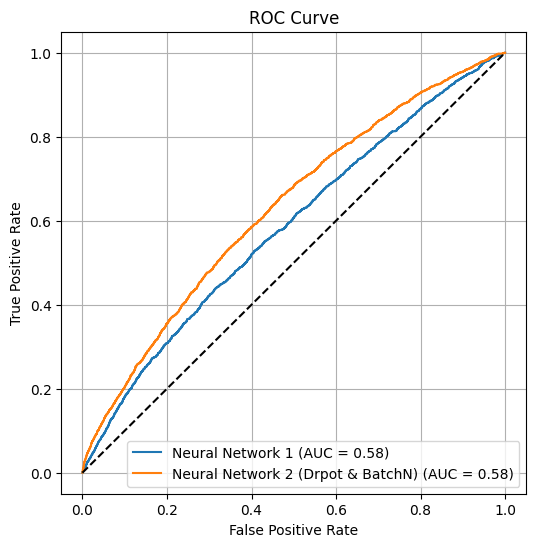

In [71]:
plt.figure(figsize=(6,6))
plt.plot(fpr1, tpr1, label=f"Neural Network 1 (AUC = {auc1:.2f})")
plt.plot(fpr2, tpr2, label=f"Neural Network 2 (Drpot & BatchN) (AUC = {auc1:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()